In [1]:
import numpy as np
from circuit import *

import soundfile as sf
import pandas as pd

duration = 240
SAMPLE_RATE = 0x4000
samples = int(duration * SAMPLE_RATE)
FLAG = "HTB{"

def encode_flag(flag, rand):
    vin = rand
    for i in range(len(flag)):
        vout = simulate_chained_circuits([ZLCircuit(1j * ord(flag[i]), 1)], vin, duration, SAMPLE_RATE)[0]
        sf.write(f'new_audio/encoded{i}.wav', np.real(vout).astype('float64'), SAMPLE_RATE, subtype='DOUBLE')

        vin = vout
        print(f'encoded {i} of {len(flag)} characters')

Looking at simulate_chained_circuits and simulate_chained_circuits_ we can extract all the variables which are constant for that specific character and come up with the following function:

In [2]:
def make_circuit(flag_char):
    c = ZLCircuit(1j * ord(flag_char), 1)
    chain = chained_to_state_space([c])
    n = 1
    vout_coeffs = chain[0]
    vin_coeff = chain[1]

    state = np.zeros(n, dtype='complex')

    A = np.diag(np.ones(n - 1, dtype='complex'), k=1)
    A[-1, :] = vout_coeffs

    B = np.zeros(n, dtype='complex')
    B[-1] = vin_coeff

    # x(t) = A * x(t - 1) + B * u(t)
    h = 1 / SAMPLE_RATE
    multiplier = h / 24 * (
        A@A@A * h**3 + 4 * A@A * h**2 + 12 * A * h + 24 * np.eye(n)
    ) # rk4
    xn_coeff = (np.eye(state.shape[0]) + multiplier @ A)
    return (multiplier, B, xn_coeff)

what is left are the following calculations which depend on the input:
```python
    output = np.zeros(len(times), dtype='complex')
    state = np.zeros(1, dtype='complex')
    B_un = np.transpose(np.dot(multiplier, np.transpose(np.outer(V_in, B))))

    for i in range(len(times)):
        state = xn_coeff @ state + B_un[i]
        output[i] = state[0]

    return output, times
```

plotting B_un and comparing it to V_in on the first iteration:

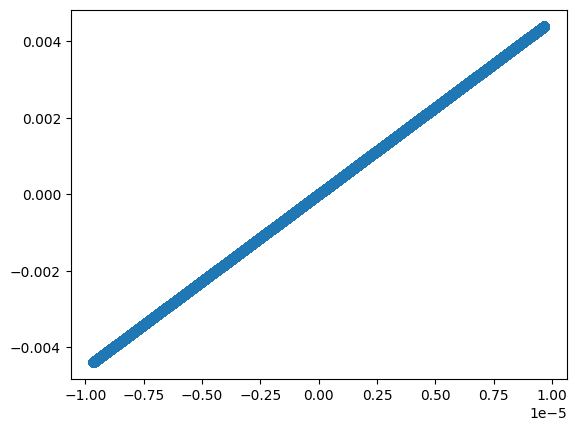

In [3]:
import matplotlib.pyplot as plt

multiplier, B, xn_coeff = make_circuit('H')
rand = np.random.uniform(-1, 1, samples)
B_un = np.transpose(np.dot(multiplier, np.transpose(np.outer(rand, B))))

plt.scatter(B_un.real, B_un.imag)

In [4]:
df = pd.DataFrame({'random': rand.reshape(-1), 'B_un_real': B_un.reshape(-1).real, 'B_un_imag': B_un.reshape(-1).imag})
df.corr()

,random,B_un_real,B_un_imag
random,1.0,1.0,1.0
B_un_real,1.0,1.0,1.0
B_un_imag,1.0,1.0,1.0


Seeing that there is a full correlation for the individual values of rand and B_un we can ignore the further values since we get the output of all the iterations in the loop
Now we can change the function to take arbitrary sized inputs 

In [5]:
@nb.jit(nopython=True)
def get_vout(V_in, multiplier, B, xn_coeff):
    output = np.zeros(len(V_in), dtype='complex')
    B_un = np.transpose(np.dot(multiplier, np.transpose(np.outer(V_in, B))))
    state = np.zeros(1, dtype='complex')

    for i in range(len(V_in)):
        state = xn_coeff @ state + B_un[i]
        output[i] = state[0]

    return output

To test this we can run the function with different sized inputs:

In [6]:
rand = np.random.uniform(-1, 1, samples)
out_100 = get_vout(rand[:100] ,*make_circuit('H'))
out_10 = get_vout(rand[:10] ,*make_circuit('H'))
df = pd.DataFrame({'10': out_10, '100': out_100[:10]})
df['diff'] = df['10'] - df['100']
df

,10,100,diff
0,0.000008+0.003835j,0.000008+0.003835j,0.0+0.0j
1,0.000029+0.005492j,0.000029+0.005492j,0.0+0.0j
2,0.000050+0.004313j,0.000050+0.004313j,0.0+0.0j
3,0.000064+0.001939j,0.000064+0.001939j,0.0+0.0j
4,0.000080+0.005058j,0.000080+0.005058j,0.0+0.0j
5,0.000099+0.003700j,0.000099+0.003700j,0.0+0.0j
6,0.000121+0.006614j,0.000121+0.006614j,0.0+0.0j
7,0.000150+0.006219j,0.000150+0.006219j,0.0+0.0j
8,0.000185+0.009812j,0.000185+0.009812j,0.0+0.0j
9,0.000224+0.007872j,0.000224+0.007872j,0.0+0.0j


Now we can write a loop to create the output for multiple characters of the flag

In [7]:
def test(input):
    df = pd.DataFrame()
    for i, char in enumerate(FLAG):
        circuit = make_circuit(char)
        output = get_vout(input, *circuit)
        df[f'{i}'] = output
        input = output
    return(df)

df = test(rand[:1])
df


,0,1,2,3
0,0.000008+0.003835j,-0.00002+0.00000j,-5.365588e-10-7.919680e-08j,5.945353e-10-6.259835e-12j


Since we a fast way to calculate the real output for our first 4 characters which are known: "HTB{", we can use this to find out the input

In [8]:
from scipy.optimize import minimize

def objective(x):
    return np.linalg.norm(df.iloc[0].values.real - test(x).iloc[0].values.real)

x0 = np.random.uniform(-1, 1, 1)

res = minimize(objective, x0, method='L-BFGS-B')
print(res.x[0])
print(rand[0])

0.8726153651484871
0.8726152480689529


We can correctly get our random value back from the outputs
So now we can do the same thing with the values given to us

In [10]:
expected_output = [sf.read(f'audio/encoded{i}.wav', stop=1)[0][0] for i in range(15)]
expected_output = np.array(expected_output)
expected_output

array([-1.09132275e-06,  2.54639015e-06,  6.94949565e-11, -7.70040649e-11,
       -7.34153962e-15,  1.54207156e-15,  1.90171022e-19, -6.26551500e-20,
       -8.97051556e-24,  2.21704853e-24,  4.03063346e-28, -8.81076246e-29,
       -1.97472595e-32,  3.28118277e-33,  1.10139686e-36])

In [11]:
def objective(x):
    return np.linalg.norm(expected_output[:4] - test(x).iloc[0].values.real)

x0 = np.random.uniform(-1, 1, 1)

res = minimize(objective, x0, method='L-BFGS-B')
res.x[0]

-0.11302110405489794

In [12]:
expected_output[:4] - test(res.x)

,0,1,2,3
0,0.000000+0.000497j,-4.434351e-12+1.212282e-08j,-1.210204e-16-1.025757e-08j,1.340969e-16-8.107736e-13j


In [13]:
from string import ascii_letters

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

ALL = ascii_letters + "_0123456789{}"
BUILD_FLAG=""
for i in range(15):
    results = []
    for c in ALL:
        FLAG = BUILD_FLAG + c
        results.append(test(res.x)[f'{len(BUILD_FLAG)}'].values.real)

    id = find_nearest(results, expected_output[len(BUILD_FLAG)])
    BUILD_FLAG += ALL[id]
BUILD_FLAG 

'HTB{p0le_dance}'